## Importing required libraries

In [1]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau, StepLR, CyclicLR
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.utils.class_weight import compute_class_weight


from glob import glob
from skimage.io import imread
from os import listdir

import time
import copy
from tqdm import tqdm_notebook as tqdm

settings

In [2]:
run_training = False
retrain = False
find_learning_rate = False

## Exploring the data structure

In [3]:
files = listdir(r"C:\Users\anush\Desktop\machine_learning\breast cancer images")
print(len(files))
files[0:10]

280


['10253',
 '10254',
 '10255',
 '10256',
 '10257',
 '10258',
 '10259',
 '10260',
 '10261',
 '10262']

In [5]:
files = listdir(r"C:\Users\anush\Desktop\machine_learning\breast cancer images\IDC_regular_ps50_idx5")
len(files)

279

In [6]:
base_path=r"C:\Users\anush\Desktop\machine_learning\breast cancer images\IDC_regular_ps50_idx5"
folder=listdir(base_path)
len(folder)

279

In [7]:
total_images = 0
for n in range(len(folder)):
    patient_id = folder[n]
    for c in [0, 1]:
        patient_path = base_path + "/" + patient_id
        class_path = patient_path + "/" + str(c) + "/"
        subfiles = listdir(class_path)
        total_images += len(subfiles)

In [8]:
total_images

277524

In [9]:
data = pd.DataFrame(index=np.arange(0, total_images), columns=["patient_id", "path", "target"])

k = 0
for n in range(len(folder)):
    patient_id = folder[n]
    patient_path = base_path + "/" + patient_id 
    for c in [0,1]:
        class_path = patient_path + "/" + str(c) + "/"
        subfiles = listdir(class_path)
        for m in range(len(subfiles)):
            image_path = subfiles[m]
            data.iloc[k]["path"] = class_path + image_path
            data.iloc[k]["target"] = c
            data.iloc[k]["patient_id"] = patient_id
            k += 1  

data.head()

patient_id                                               path target
0      10253  C:\Users\anush\Desktop\machine_learning\breast...      0
1      10253  C:\Users\anush\Desktop\machine_learning\breast...      0
2      10253  C:\Users\anush\Desktop\machine_learning\breast...      0
3      10253  C:\Users\anush\Desktop\machine_learning\breast...      0
4      10253  C:\Users\anush\Desktop\machine_learning\breast...      0

In [10]:
data.shape

(277524, 3)

## Exploratory analysis
What do we know about our data?

In [11]:
cancer_perc = data.groupby("patient_id").target.value_counts() / data.groupby("patient_id").target.size()
print("Grouping done")


Grouping done


In [12]:
cancer_perc = data.groupby("patient_id").agg(
    target_sum=('target', lambda x: (x == 1).sum()), 
    total=('target', 'size')
)
cancer_perc['percentage'] = (cancer_perc['target_sum'] / cancer_perc['total']) * 100
print("Percentage calculation done")


Percentage calculation done


In [13]:
import dask.dataframe as dd
ddata = dd.from_pandas(data, npartitions=10)
cancer_perc = ddata.groupby("patient_id").target.value_counts() / ddata.groupby("patient_id").target.size()
cancer_perc = cancer_perc.compute()


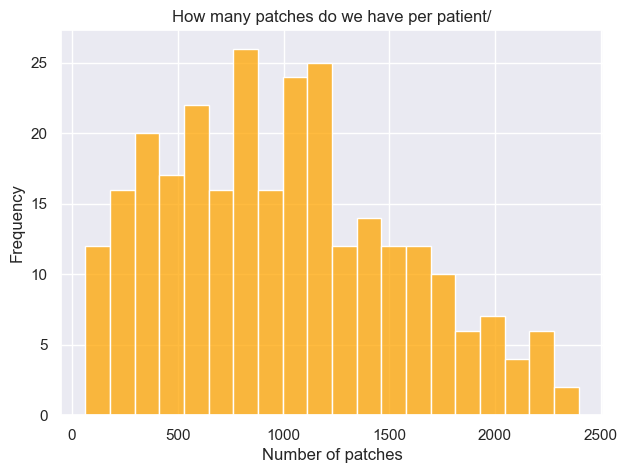

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(7, 5))
sns.histplot(data.groupby("patient_id").size(), color="Orange", bins=20, ax=ax)
ax.set_xlabel("Number of patches")
ax.set_ylabel("Frequency")
ax.set_title("How many patches do we have per patient/")
plt.show()

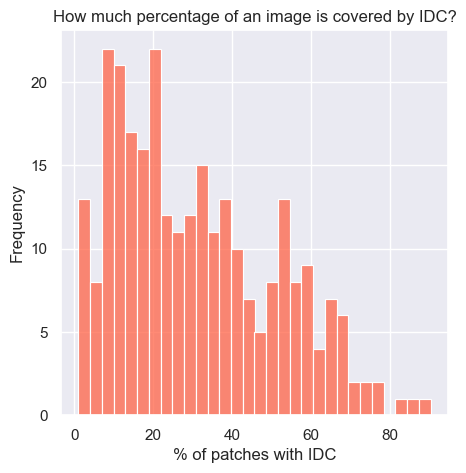

In [15]:
fig, ax=plt.subplots(1,1,figsize=(5,5))
sns.histplot(cancer_perc.loc[:, 1]*100, ax=ax, color="Tomato", kde=False, bins=30)
ax.set_title("How much percentage of an image is covered by IDC?")
ax.set_ylabel("Frequency")
ax.set_xlabel("% of patches with IDC")
plt.show();

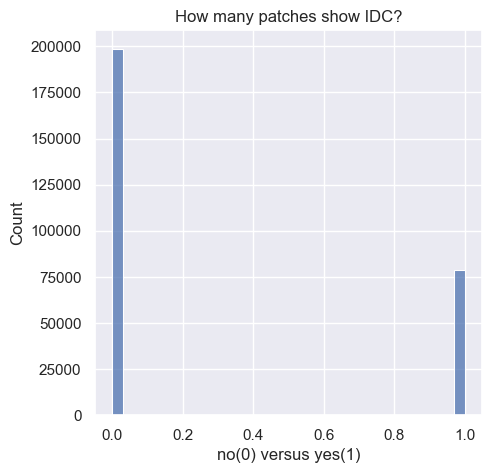

In [16]:
fig, ax=plt.subplots(1,1,figsize=(5,5))
sns.histplot(data.target, palette="Set2");
ax.set_xlabel("no(0) versus yes(1)")
ax.set_title("How many patches show IDC?");
plt.show();

In [17]:
data.target = data.target.astype(int)

In [18]:
pos_selection = np.random.choice(data[data.target==1].index.values, size=50, replace=False)
neg_selection = np.random.choice(data[data.target==0].index.values, size=50, replace=False)

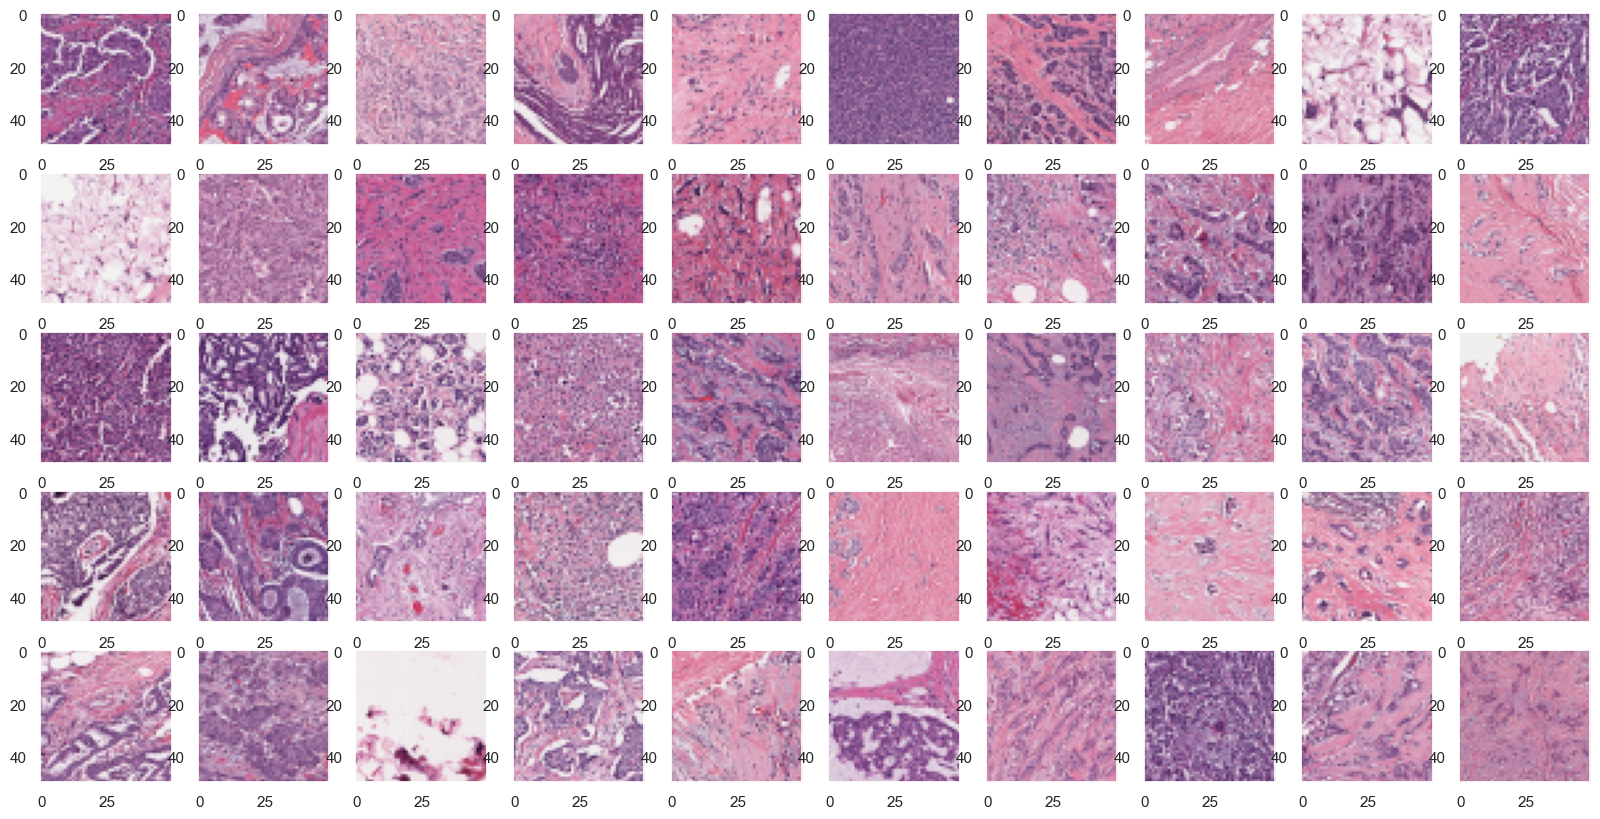

In [19]:
fig, ax = plt.subplots(5,10,figsize=(20,10))

for n in range(5):
    for m in range(10):
        idx = pos_selection[m + 10*n]
        image = imread(data.loc[idx, "path"])
        ax[n,m].imshow(image)
        ax[n,m].grid(False)

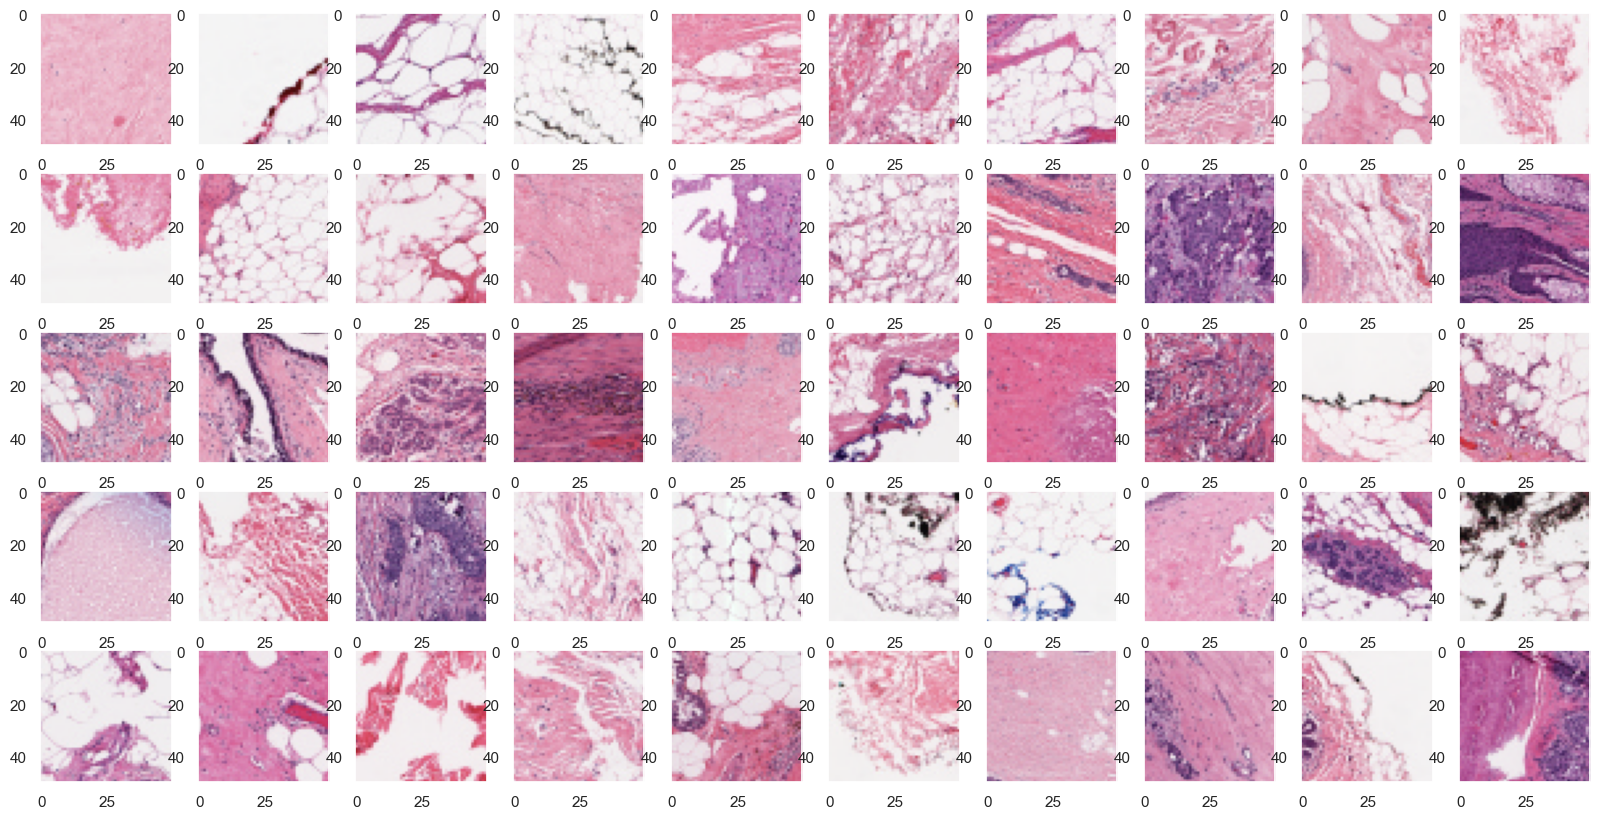

In [20]:
fig, ax = plt.subplots(5,10,figsize=(20,10))

for n in range(5):
    for m in range(10):
        idx = neg_selection[m + 10*n]
        image = imread(data.loc[idx, "path"])
        ax[n,m].imshow(image)
        ax[n,m].grid(False)

In [21]:
def extract_coords(df):
    coord = df.path.str.rsplit("_", n=4, expand=True)
    coord = coord.drop([0, 1, 4], axis=1)
    coord = coord.rename({2: "x", 3: "y"}, axis=1)
    coord.loc[:, "x"] = coord.loc[:,"x"].str.replace("x", "", case=False).astype(int)
    coord.loc[:, "y"] = coord.loc[:,"y"].str.replace("y", "", case=False).astype(int)
    df.loc[:, "x"] = coord.x.values
    df.loc[:, "y"] = coord.y.values
    return df

def get_cancer_dataframe(patient_id, cancer_id):
    path = base_path +"/"+ patient_id + "/" + cancer_id
    files = listdir(path)
    dataframe = pd.DataFrame(files, columns=["filename"])
    path_names = path + "/" + dataframe.filename.values
    dataframe = dataframe.filename.str.rsplit("_", n=4, expand=True)
    dataframe.loc[:, "target"] = int(cancer_id)
    dataframe.loc[:, "path"] = path_names
    dataframe = dataframe.drop([0, 1, 4], axis=1)
    dataframe = dataframe.rename({2: "x", 3: "y"}, axis=1)
    dataframe.loc[:, "x"] = dataframe.loc[:,"x"].str.replace("x", "", case=False).astype(int)
    dataframe.loc[:, "y"] = dataframe.loc[:,"y"].str.replace("y", "", case=False).astype(int)
    return dataframe

def get_patient_dataframe(patient_id):
    df_0 = get_cancer_dataframe(patient_id, "0")
    df_1 = get_cancer_dataframe(patient_id, "1")
    patient_df = pd.concat([df_0, df_1], ignore_index=True)
    return patient_df

In [22]:
example = get_patient_dataframe(data.patient_id.values[0])
example.head()

x     y  target                                               path
0  1001  1001       0  C:\Users\anush\Desktop\machine_learning\breast...
1  1001  1051       0  C:\Users\anush\Desktop\machine_learning\breast...
2  1001  1101       0  C:\Users\anush\Desktop\machine_learning\breast...
3  1001  1151       0  C:\Users\anush\Desktop\machine_learning\breast...
4  1001  1201       0  C:\Users\anush\Desktop\machine_learning\breast...

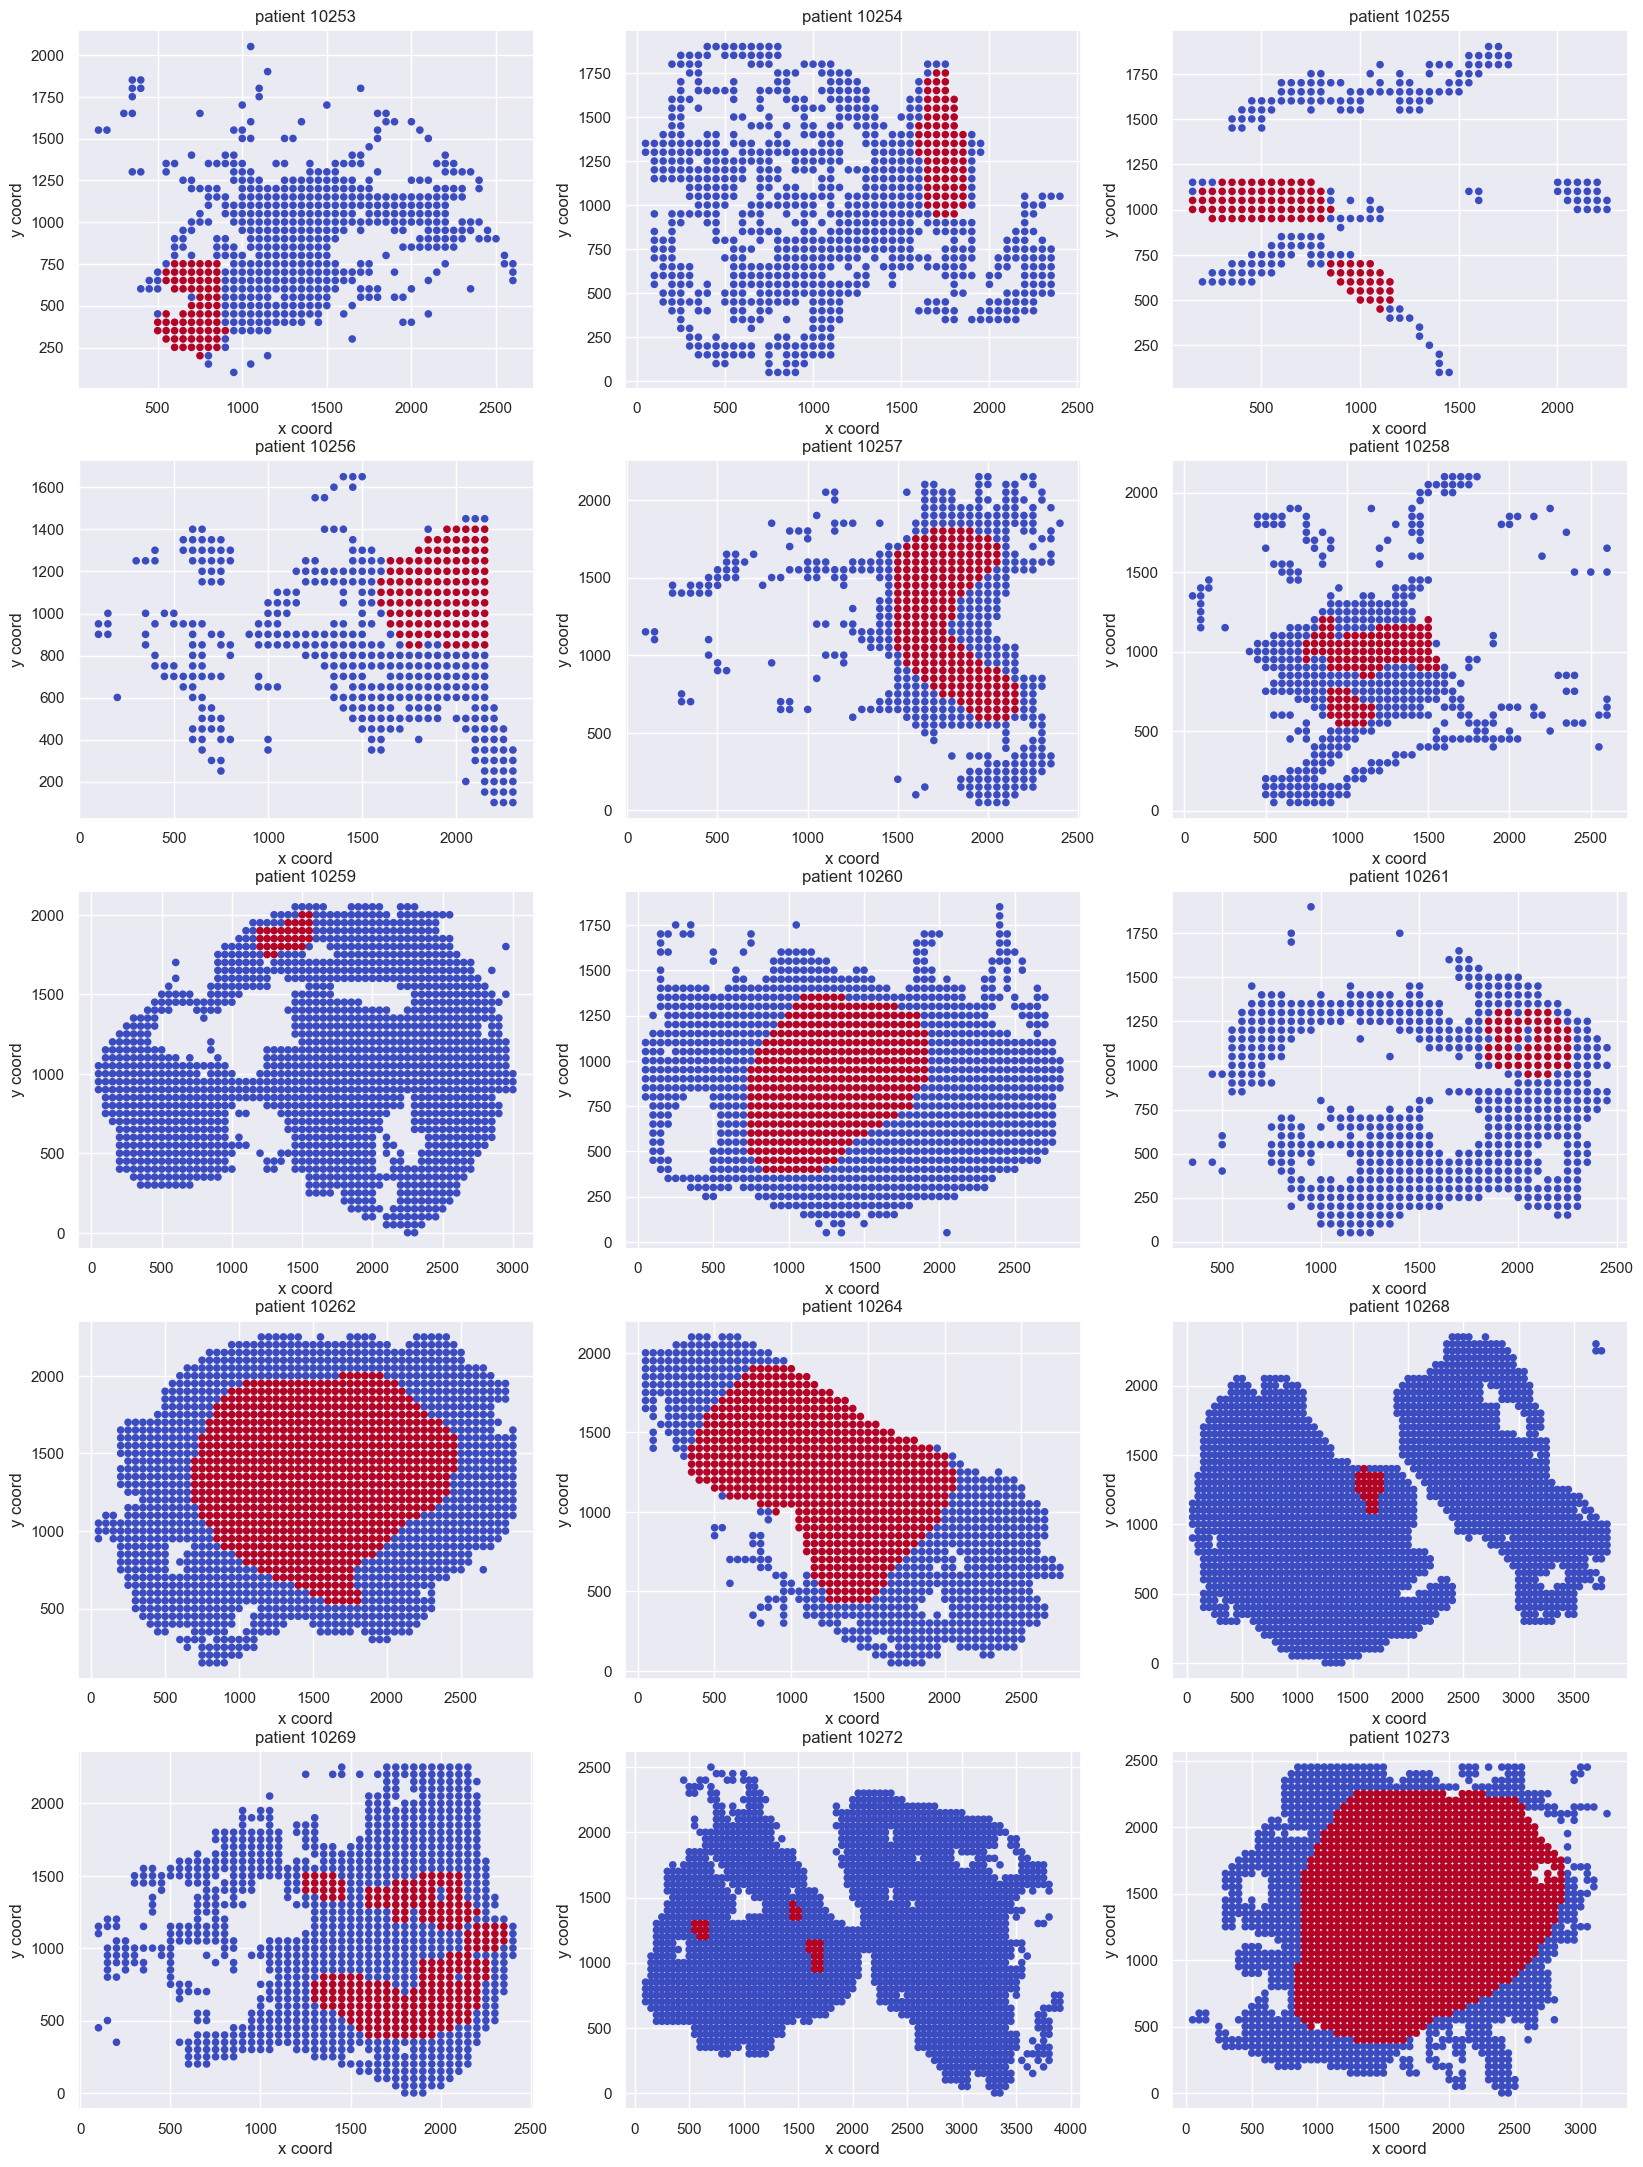

In [23]:
fig, ax = plt.subplots(5,3,figsize=(20, 27))

patient_ids = data.patient_id.unique()

for n in range(5):
    for m in range(3):
        patient_id = patient_ids[m + 3*n]
        example_df = get_patient_dataframe(patient_id)
        
        ax[n,m].scatter(example_df.x.values, example_df.y.values, c=example_df.target.values, cmap="coolwarm", s=20);
        ax[n,m].set_title("patient " + patient_id)
        ax[n,m].set_xlabel("x coord")
        ax[n,m].set_ylabel("y coord")

In [24]:
# Checking if image files are accessible
from os.path import exists
for image_path in data["path"]:
    if not exists(image_path):
        print(f"Missing: {image_path}")


In [26]:
def visualise_breast_tissue(patient_id, pred_df=None):
    example_df = get_patient_dataframe(patient_id)
    max_point = [example_df.y.max()-1, example_df.x.max()-1]
    grid = 255*np.ones(shape = (max_point[0] + 50, max_point[1] + 50, 3)).astype(np.uint8)
    mask = 255*np.ones(shape = (max_point[0] + 50, max_point[1] + 50, 3)).astype(np.uint8)
    if pred_df is not None:
        patient_df = pred_df[pred_df.patient_id == patient_id].copy()
    mask_proba = np.zeros(shape = (max_point[0] + 50, max_point[1] + 50, 1)).astype(float)
    
    broken_patches = []
    for n in range(len(example_df)):
        try:
            image = imread(example_df.path.values[n])
            
            target = example_df.target.values[n]
            
            x_coord = int(example_df.x.values[n])
            y_coord = int(example_df.y.values[n])
            x_start = x_coord - 1
            y_start = y_coord - 1
            x_end = x_start + 50
            y_end = y_start + 50

            grid[y_start:y_end, x_start:x_end] = image
            if target == 1:
                mask[y_start:y_end, x_start:x_end, 0] = 250
                mask[y_start:y_end, x_start:x_end, 1] = 0
                mask[y_start:y_end, x_start:x_end, 2] = 0
            if pred_df is not None:
                
                proba = patient_df[
                    (patient_df.x==x_coord) & (patient_df.y==y_coord)].proba
                mask_proba[y_start:y_end, x_start:x_end, 0] = float(proba)

        except ValueError:
            broken_patches.append(example_df.path.values[n])
    
    
    return grid, mask, broken_patches, mask_proba

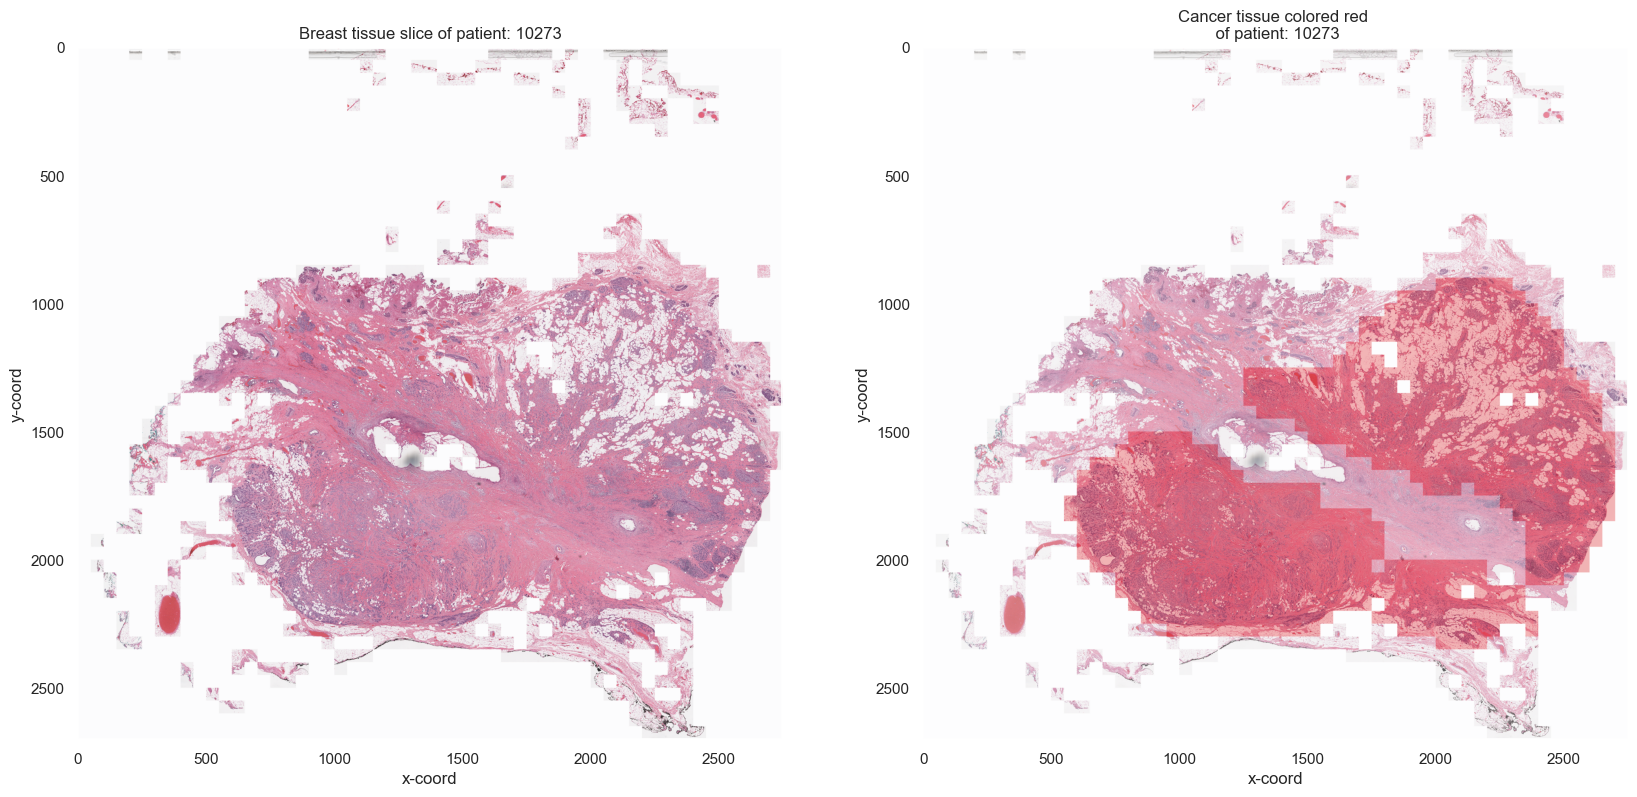

In [27]:
example = "13616"
grid, mask, broken_patches,_ = visualise_breast_tissue(example)

fig, ax = plt.subplots(1,2,figsize=(20,10))
ax[0].imshow(grid, alpha=0.9)
ax[1].imshow(mask, alpha=0.8)
ax[1].imshow(grid, alpha=0.7)
ax[0].grid(False)
ax[1].grid(False)
for m in range(2):
    ax[m].set_xlabel("x-coord")
    ax[m].set_ylabel("y-coord")
ax[0].set_title("Breast tissue slice of patient: " + patient_id)
ax[1].set_title("Cancer tissue colored red \n of patient: " + patient_id);

In [28]:
broken_patches


[]

In [29]:
BATCH_SIZE = 32
NUM_CLASSES = 2

OUTPUT_PATH = ""
MODEL_PATH =r"C:\Users\anush\Desktop\machine_learning\breast cancer model"


LOSSES_PATH = r"C:\Users\anush\Desktop\machine_learning\breast cancer model"

In [30]:
torch.manual_seed(0)
np.random.seed(0)

In [31]:
data.head()
data.loc[:, "target"] = data.target.astype(str)
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 277524 entries, 0 to 277523
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   patient_id  277524 non-null  object
 1   path        277524 non-null  object
 2   target      277524 non-null  object
dtypes: object(3)
memory usage: 13.5+ MB


In [32]:
patients = data.patient_id.unique()

train_ids, sub_test_ids = train_test_split(patients,
                                           test_size=0.3,
                                           random_state=0)
test_ids, dev_ids = train_test_split(sub_test_ids, test_size=0.5, random_state=0)

In [33]:
print(len(train_ids)/patients.shape[0]*100, len(dev_ids)/patients.shape[0]*100, len(test_ids)/patients.shape[0]*100)

69.89247311827957 15.053763440860216 15.053763440860216


In [34]:
print(len(train_ids), len(dev_ids), len(test_ids))


195 42 42


In [35]:
train_df = data.loc[data.patient_id.isin(train_ids),:].copy()
test_df = data.loc[data.patient_id.isin(test_ids),:].copy()
dev_df = data.loc[data.patient_id.isin(dev_ids),:].copy()

train_df = extract_coords(train_df)
test_df = extract_coords(test_df)
dev_df = extract_coords(dev_df)

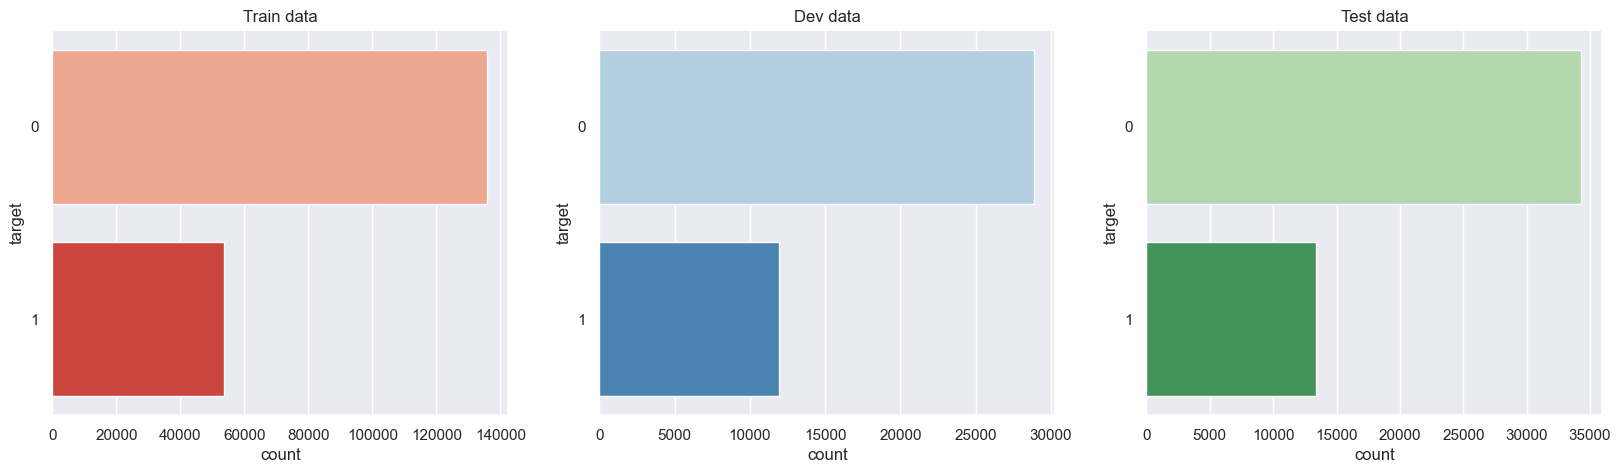

In [36]:
fig, ax = plt.subplots(1,3,figsize=(20,5))
sns.countplot(train_df.target, ax=ax[0], palette="Reds")
ax[0].set_title("Train data")
sns.countplot(dev_df.target, ax=ax[1], palette="Blues")
ax[1].set_title("Dev data")
sns.countplot(test_df.target, ax=ax[2], palette="Greens");
ax[2].set_title("Test data");

In [37]:
from torchvision import transforms

def my_transform(key="train", plot=False):
    # Defining the transformation sequences
    train_sequence = [
        transforms.Resize((50,50)),  # Resize the image
        transforms.RandomHorizontalFlip(),  # Random horizontal flip
        transforms.RandomVerticalFlip(),  # Random vertical flip
        transforms.RandomRotation(degrees=30),  # Custom Random Rotation
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2)  # Custom color jitter
    ]
    
    # For validation or testing, you can add only resizing
    val_sequence = [transforms.Resize((50,50))]
    
    if plot == False:
        # Convert image to tensor and normalize for both train and validation
        train_sequence.extend([
            transforms.ToTensor(),  # Convert image to tensor
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Normalize the image
        ])
        
        val_sequence.extend([
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Normalize the image
        ])
    
    # Apply the correct transformation based on key (train/val)
    data_transforms = {'train': transforms.Compose(train_sequence),
                       'val': transforms.Compose(val_sequence)}
    
    return data_transforms[key]


In [38]:
class BreastCancerDataset(Dataset):
    
    def __init__(self, df, transform=None):
        self.states = df
        self.transform = transform
      
    def __len__(self):
        return len(self.states)
        
    def __getitem__(self, idx):
        patient_id = self.states.patient_id.values[idx]
        x_coord = self.states.x.values[idx]
        y_coord = self.states.y.values[idx]
        image_path = self.states.path.values[idx] 
        image = Image.open(image_path)
        image = image.convert('RGB')
        
        if self.transform:
            image = self.transform(image)
        
        if "target" in self.states.columns.values:
            target = np.int64(self.states.target.values[idx])  
        else:
            target = None
            
        return {"image": image,
                "label": target,
                "patient_id": patient_id,
                "x": x_coord,
                "y": y_coord}


In [39]:
train_dataset = BreastCancerDataset(train_df, transform=my_transform(key="train"))
dev_dataset = BreastCancerDataset(dev_df, transform=my_transform(key="val"))
test_dataset = BreastCancerDataset(test_df, transform=my_transform(key="val"))

In [40]:
image_datasets = {"train": train_dataset, "dev": dev_dataset, "test": test_dataset}
dataset_sizes = {x: len(image_datasets[x]) for x in ["train", "dev", "test"]}

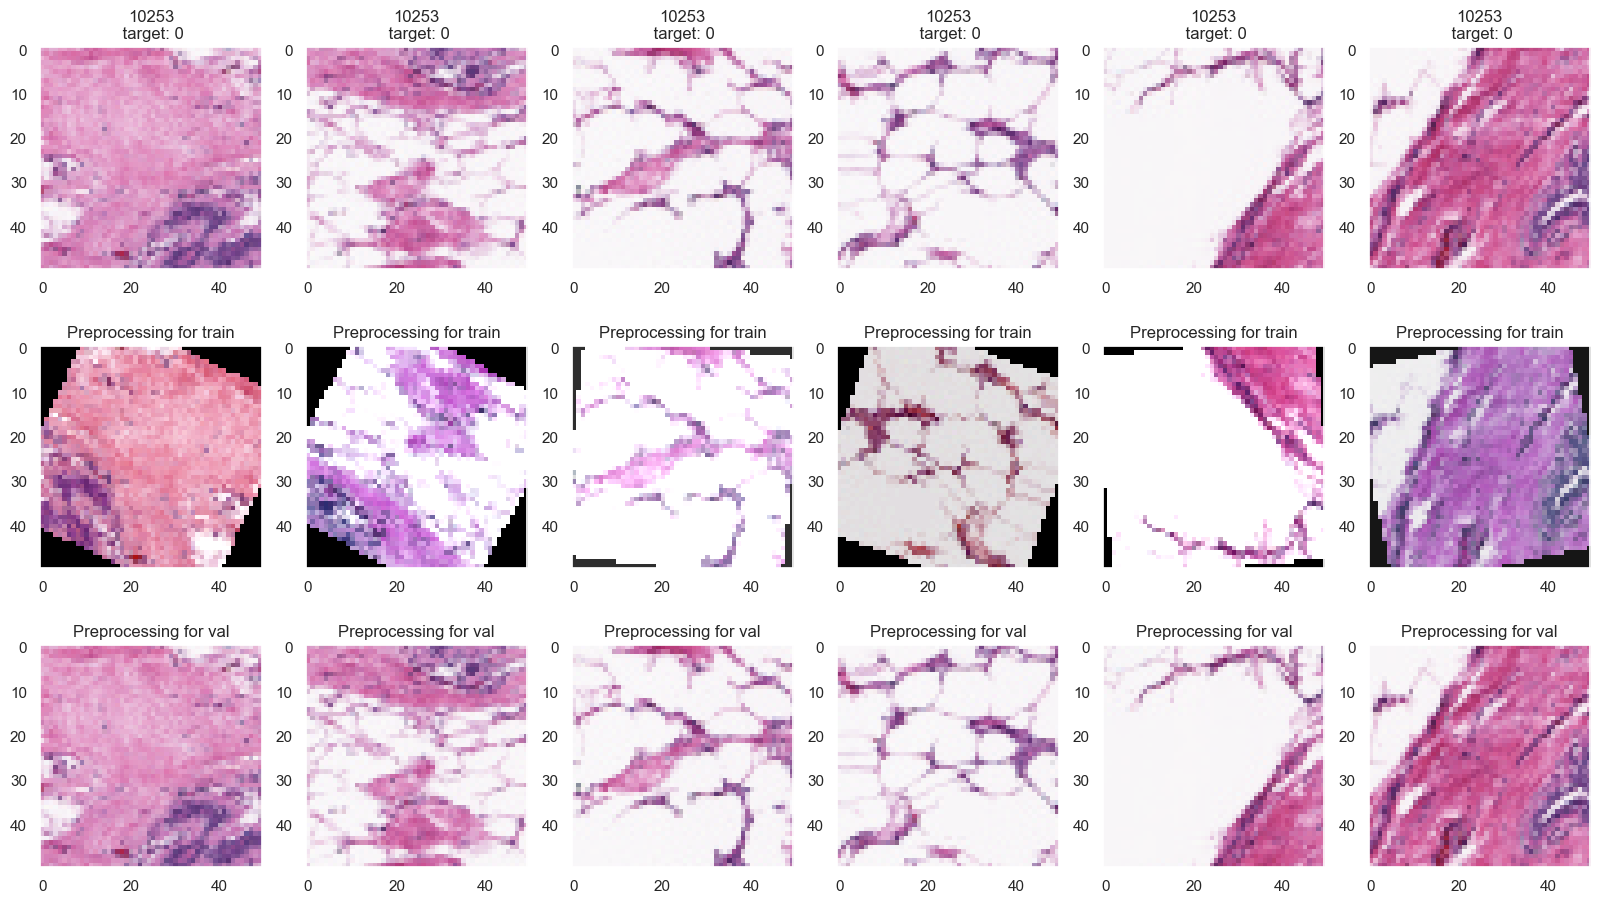

In [41]:
fig, ax = plt.subplots(3,6,figsize=(20,11))

train_transform = my_transform(key="train", plot=True)
val_transform = my_transform(key="val", plot=True)

for m in range(6):
    filepath = train_df.path.values[m]
    image = Image.open(filepath)
    ax[0,m].imshow(image)
    transformed_img = train_transform(image)
    ax[1,m].imshow(transformed_img)
    ax[2,m].imshow(val_transform(image))
    ax[0,m].grid(False)
    ax[1,m].grid(False)
    ax[2,m].grid(False)
    ax[0,m].set_title(train_df.patient_id.values[m] + "\n target: " + train_df.target.values[m])
    ax[1,m].set_title("Preprocessing for train")
    ax[2,m].set_title("Preprocessing for val")

In [42]:
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
dev_dataloader = DataLoader(dev_dataset, batch_size=BATCH_SIZE, shuffle=False, drop_last=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, drop_last=False)

In [43]:
dataloaders = {"train": train_dataloader, "dev": dev_dataloader, "test": test_dataloader}

In [44]:
print(len(dataloaders["train"]), len(dataloaders["dev"]), len(dataloaders["test"]))

5911 1273 1489


In [45]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [46]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [47]:
model = torchvision.models.resnet18(pretrained=False)
run_training=True
if run_training:
    model.load_state_dict(torch.load(r"C:\Users\anush\Desktop\machine_learning\pretrained pytorch  model\resnet18-5c106cde.pth"))
num_features = model.fc.in_features
print(num_features)

model.fc = nn.Sequential(
    nn.Linear(num_features, 512),
    nn.ReLU(),
    nn.BatchNorm1d(512),
    nn.Dropout(0.5),
    
    nn.Linear(512, 256),
    nn.ReLU(),
    nn.BatchNorm1d(256),
    nn.Dropout(0.5),
    
    nn.Linear(256, NUM_CLASSES))

def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)

model.apply(init_weights)
model = model.to(device)

512


In [48]:
weights = compute_class_weight(y=train_df.target.values, class_weight="balanced", classes=train_df.target.unique())    
class_weights = torch.FloatTensor(weights)
if device.type=="cuda":
    class_weights = class_weights.cuda()
print(class_weights)

tensor([0.6973, 1.7673])


In [49]:
train_df.target.unique()


array(['0', '1'], dtype=object)

In [50]:
criterion = nn.CrossEntropyLoss(weight=class_weights)

In [51]:
def f1_score(preds, targets):
    
    tp = (preds*targets).sum().to(torch.float32)
    fp = ((1-targets)*preds).sum().to(torch.float32)
    fn = (targets*(1-preds)).sum().to(torch.float32)
    
    epsilon = 1e-7
    precision = tp / (tp + fp + epsilon)
    recall = tp / (tp + fn + epsilon)
    
    f1_score = 2 * precision * recall/(precision + recall + epsilon)
    return f1_score

In [52]:
def train_loop(model, criterion, optimizer, lr_find=False, scheduler=None, num_epochs=3, lam=0.0):
    since = time.time()
    phases = ["train"] if lr_find else ["train", "dev", "test"]
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    loss_dict = {"train": [], "dev": [], "test": []}
    lam_tensor = torch.tensor(lam, device=device)
    
    running_loss_dict = {"train": [], "dev": [], "test": []}
    
    lr_find_loss = []
    lr_find_lr = []
    smoothing = 0.2
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        
        for phase in phases:
            model.train() if phase == "train" else model.eval()

            running_loss = 0.0
            running_corrects = 0
            
            tk0 = tqdm(dataloaders[phase], total=int(len(dataloaders[phase])))

            counter = 0
            for bi, d in enumerate(tk0):
                inputs = d["image"]
                labels = d["label"]
                inputs = inputs.to(device, dtype=torch.float)
                labels = labels.to(device, dtype=torch.long)
                
                optimizer.zero_grad()
                
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                        if scheduler is not None:
                            scheduler.step() 
                            if lr_find:
                                lr_step = optimizer.state_dict()["param_groups"][0]["lr"]
                                lr_find_lr.append(lr_step)
                                if counter == 0:
                                    lr_find_loss.append(loss.item())
                                else:
                                    smoothed_loss = smoothing * loss.item() + (1 - smoothing) * lr_find_loss[-1]
                                    lr_find_loss.append(smoothed_loss)
            
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)                       
     
                counter += 1
                
                tk0.set_postfix({'loss': running_loss / (counter * dataloaders[phase].batch_size),
                                 'accuracy': running_corrects.double() / (counter * dataloaders[phase].batch_size)})
                running_loss_dict[phase].append(running_loss / (counter * dataloaders[phase].batch_size))
                
            epoch_loss = running_loss / dataset_sizes[phase]
            loss_dict[phase].append(epoch_loss)
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
            
            if phase == 'dev' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                
        print()
        
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))              
    
    model.load_state_dict(best_model_wts)
    results = {"model": model,
               "loss_dict": loss_dict,
               "running_loss_dict": running_loss_dict,
               "lr_find": {"lr": lr_find_lr, "loss": lr_find_loss}}
    return results


In [53]:
start_lr = 1e-6
end_lr = 0.1

In [54]:
def get_lr_search_scheduler(optimizer, min_lr, max_lr, max_iterations):
    # max_iterations should be the number of steps within num_epochs_*epoch_iterations
    # this way the learning rate increases linearily within the period num_epochs*epoch_iterations 
    scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer=optimizer, 
                                               base_lr=min_lr,
                                               max_lr=max_lr,
                                               step_size_up=max_iterations,
                                               step_size_down=max_iterations,
                                               mode="triangular")
    
    return scheduler

def get_scheduler(optimiser, min_lr, max_lr, stepsize):
    # suggested_stepsize = 2*num_iterations_within_epoch
    stepsize_up = int(stepsize/2)
    scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer=optimiser,
                                               base_lr=min_lr,
                                               max_lr=max_lr,
                                               step_size_up=stepsize_up,
                                               step_size_down=stepsize_up,
                                               mode="triangular")
    return scheduler

In [55]:
import math
find_learning_rate=True
if find_learning_rate:
    lr_find_epochs=1
    optimizer = optim.SGD(model.fc.parameters(), start_lr)
    scheduler = get_lr_search_scheduler(optimizer, start_lr, end_lr, lr_find_epochs*len(train_dataloader))
    results = train_loop(model, criterion, optimizer, lr_find=True, scheduler=scheduler, num_epochs=lr_find_epochs)
    lr_find_lr, lr_find_loss = results["lr_find"]["lr"], results["lr_find"]["loss"]
    
    find_lr_df = pd.DataFrame(lr_find_loss, columns=["smoothed loss"])
    find_lr_df.loc[:, "lr"] = lr_find_lr
    find_lr_df.to_csv("learning_rate_search.csv", index=False)
else:
    find_lr_df = pd.read_csv(MODEL_PATH + "\\" + "learning_rate_search.csv")

Epoch 0/0
----------


  0%|          | 0/5911 [00:00<?, ?it/s]

train Loss: 0.6261 Acc: 0.7189

Training complete in 97m 0s
Best val Acc: 0.000000


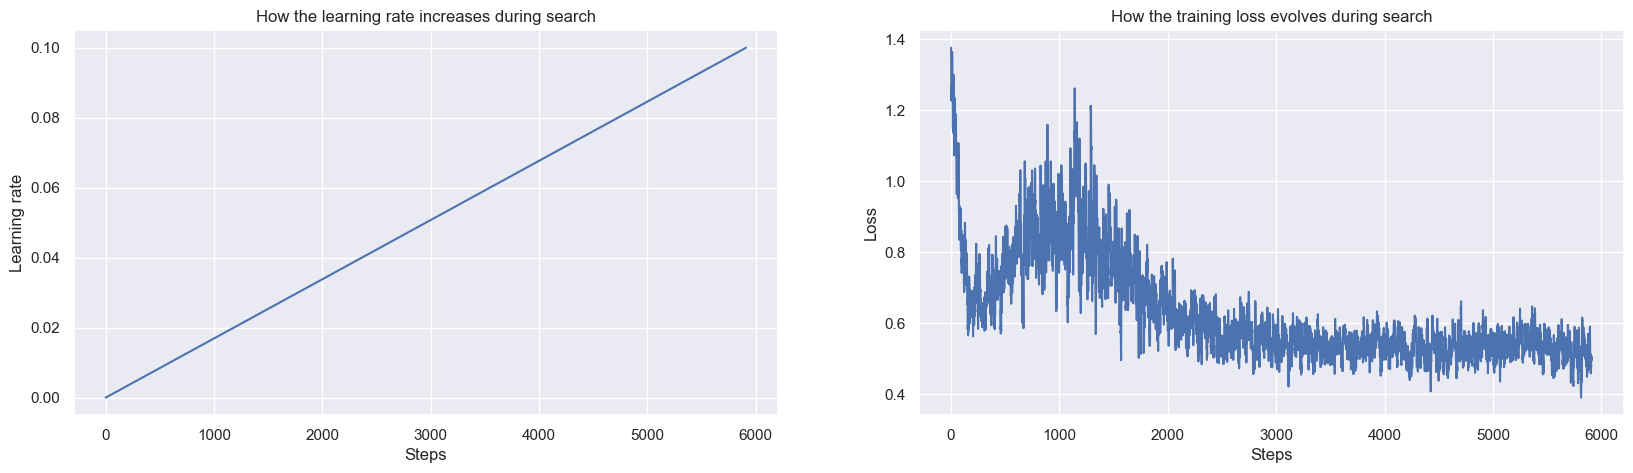

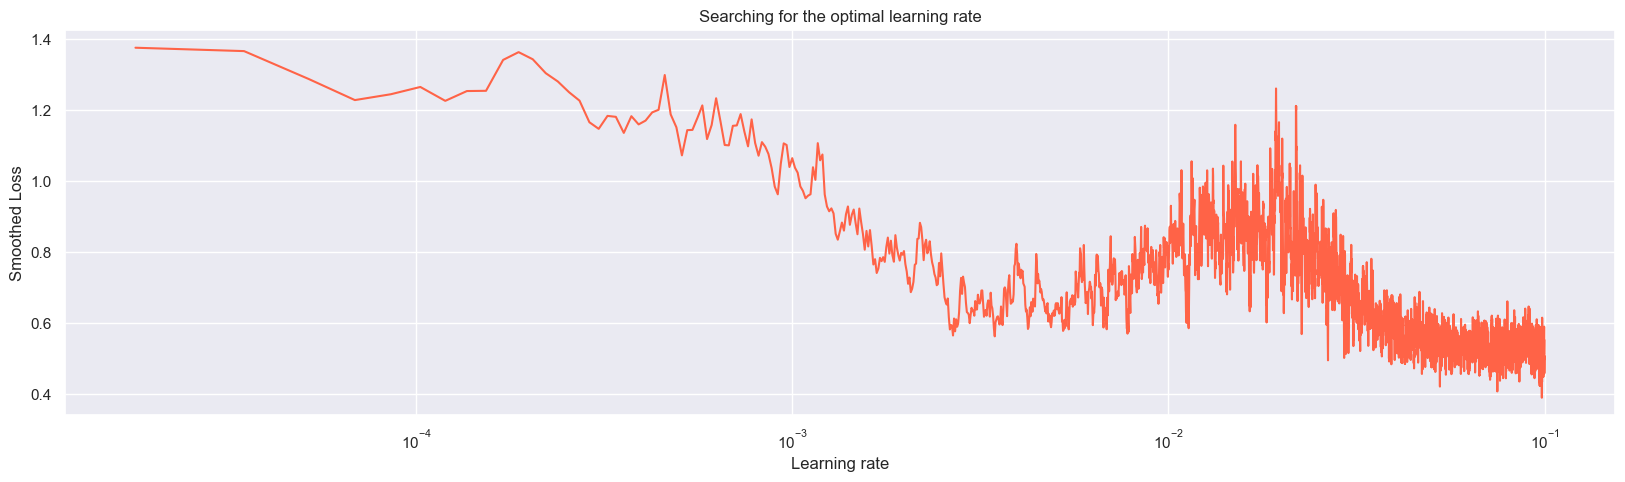

In [56]:
fig, ax = plt.subplots(1,2,figsize=(20,5))
ax[0].plot(find_lr_df.lr.values)
ax[1].plot(find_lr_df["smoothed loss"].values)
ax[0].set_xlabel("Steps")
ax[0].set_ylabel("Learning rate")
ax[1].set_xlabel("Steps")
ax[1].set_ylabel("Loss");
ax[0].set_title("How the learning rate increases during search")
ax[1].set_title("How the training loss evolves during search")

plt.figure(figsize=(20,5))
plt.plot(find_lr_df.lr.values, find_lr_df["smoothed loss"].values, '-', color="tomato");
plt.xlabel("Learning rate")
plt.xscale("log")
plt.ylabel("Smoothed Loss")
plt.title("Searching for the optimal learning rate");

In [57]:
start_lr = 1e-6
end_lr = 0.006

In [58]:
run_training=True
if run_training:
    NUM_EPOCHS = 5
    optimizer = optim.SGD(model.fc.parameters(), lr=0.01)
    scheduler = get_scheduler(optimizer, start_lr, end_lr, 2*NUM_EPOCHS)
    results = train_loop(model, criterion, optimizer, scheduler=scheduler, num_epochs = NUM_EPOCHS)
    model, loss_dict, running_loss_dict = results["model"], results["loss_dict"], results["running_loss_dict"]
    
    if device == "cpu":
        OUTPUT_PATH += ".pth"
    else:
        OUTPUT_PATH += "_cuda.pth"
        
    torch.save(model.state_dict(), OUTPUT_PATH)
    
    losses_df = pd.DataFrame(loss_dict["train"],columns=["train"])
    losses_df.loc[:, "dev"] = loss_dict["dev"]
    losses_df.loc[:, "test"] = loss_dict["test"]
    losses_df.to_csv("losses_breastcancer.csv", index=False)
    
    running_losses_df = pd.DataFrame(running_loss_dict["train"], columns=["train"])
    running_losses_df.loc[0:len(running_loss_dict["dev"])-1, "dev"] = running_loss_dict["dev"]
    running_losses_df.loc[0:len(running_loss_dict["test"])-1, "test"] = running_loss_dict["test"]
    running_losses_df.to_csv("running_losses_breastcancer.csv", index=False)
else:
    if device == "cpu":
        load_path = MODEL_PATH + "\\" +  ".pth"
    else:
        load_path = MODEL_PATH + "\\" + "_cuda.pth"
    model.load_state_dict(torch.load(load_path, map_location='cpu'))
    model.eval()
    
    losses_df = pd.read_csv(LOSSES_PATH +"\\" + "losses_breastcancer.csv")
    running_losses_df = pd.read_csv(LOSSES_PATH + "\\" + "running_losses_breastcancer.csv")

Epoch 0/4
----------


  0%|          | 0/5911 [00:00<?, ?it/s]

train Loss: 0.5777 Acc: 0.7222


  0%|          | 0/1273 [00:00<?, ?it/s]

dev Loss: 0.5558 Acc: 0.7135


  0%|          | 0/1489 [00:00<?, ?it/s]

test Loss: 0.5166 Acc: 0.7401

Epoch 1/4
----------


  0%|          | 0/5911 [00:00<?, ?it/s]

train Loss: 0.5516 Acc: 0.7417


  0%|          | 0/1273 [00:00<?, ?it/s]

dev Loss: 0.5284 Acc: 0.7473


  0%|          | 0/1489 [00:00<?, ?it/s]

test Loss: 0.4859 Acc: 0.7804

Epoch 2/4
----------


  0%|          | 0/5911 [00:00<?, ?it/s]

KeyboardInterrupt: 

## Exploring Results and errors
Loss Convergence

In [ ]:
plt.figure(figsize=(20,5))

plt.plot(losses_df["train"], '-o', label="train")
plt.plot(losses_df["dev"], '-o', label="dev")
plt.plot(losses_df["test"], '-o', label="test")
plt.xlabel("Epoch")
plt.ylabel("Weighted x-entropy")
plt.title("Loss change over epoch")
plt.legend();

In [ ]:
fig, ax = plt.subplots(3,1,figsize=(20,15))

ax[0].plot(running_losses_df["train"], '-o', label="train")
ax[0].set_xlabel("Step")
ax[0].set_ylabel("Weighted x-entropy")
ax[0].set_title("Loss change over steps")
ax[0].legend();

ax[1].plot(running_losses_df["dev"], '-o', label="dev", color="orange")
ax[1].set_xlabel("Step")
ax[1].set_ylabel("Weighted x-entropy")
ax[1].set_title("Loss change over steps")
ax[1].legend();

ax[2].plot(running_losses_df["test"], '-o', label="test", color="mediumseagreen")
ax[2].set_xlabel("Step")
ax[2].set_ylabel("Weighted x-entropy")
ax[2].set_title("Loss change over steps")
ax[2].legend();

In [102]:
def sigmoid(x):
    return 1./(1+np.exp(-x))

def evaluate_model(model, predictions_df, key):
    was_training = model.training
    model.eval()

    with torch.no_grad():
        for i, data in enumerate(dataloaders[key]):
            inputs = data["image"].to(device)
            labels = data["label"].to(device)
            
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            proba = outputs.cpu().numpy().astype(float)
            predictions_df.loc[i*BATCH_SIZE:(i+1)*BATCH_SIZE-1, "proba"] = sigmoid(proba[:, 1])
            predictions_df.loc[i*BATCH_SIZE:(i+1)*BATCH_SIZE-1, "true"] = data["label"].numpy().astype(int)
            predictions_df.loc[i*BATCH_SIZE:(i+1)*BATCH_SIZE-1, "predicted"] = preds.cpu().numpy().astype(int)
            predictions_df.loc[i*BATCH_SIZE:(i+1)*BATCH_SIZE-1, "x"] = data["x"].numpy()
            predictions_df.loc[i*BATCH_SIZE:(i+1)*BATCH_SIZE-1, "y"] = data["y"].numpy()
            predictions_df.loc[i*BATCH_SIZE:(i+1)*BATCH_SIZE-1, "patient_id"] = data["patient_id"]
            
    predictions_df = predictions_df.dropna()
    return predictions_df

In [103]:
run_training=True
if run_training:
    dev_predictions = pd.DataFrame(index = np.arange(0, dataset_sizes["dev"]), columns = ["true", "predicted", "proba"])
    test_predictions = pd.DataFrame(index = np.arange(0, dataset_sizes["test"]), columns = ["true", "predicted", "proba"])

    dev_predictions = evaluate_model(model, dev_predictions, "dev")
    test_predictions = evaluate_model(model, test_predictions, "test")
    
    dev_predictions.to_csv("dev_predictions.csv", index=False)
    test_predictions.to_csv("test_predictions.csv", index=False)
    
else:
    
    dev_predictions = pd.read_csv(LOSSES_PATH +"\\" + "dev_predictions.csv")
    test_predictions = pd.read_csv(LOSSES_PATH + "\\" + "test_predictions.csv")
    
    dev_predictions.patient_id = dev_predictions.patient_id.astype(str)

In [ ]:
fig, ax = plt.subplots(3,3,figsize=(20,20))

for n in range(3):

    idx = dev_predictions.patient_id.unique()[n]
    grid, mask, broken_patches, mask_proba = visualise_breast_tissue(idx, pred_df=dev_predictions)


    ax[n, 0].imshow(grid, alpha=0.9)
    ax[n, 1].imshow(mask, alpha=0.8)
    ax[n, 1].imshow(grid, alpha=0.7)
    ax[n, 2].imshow(mask_proba[:,:,0], cmap="YlOrRd")

    for m in range(3):
        ax[n, m].set_xlabel("y-coord")
        ax[n, m].set_ylabel("x-coord")
        ax[n, m].grid(False)
        
    ax[n, 0].set_title("Breast tissue slice of patient: " + patient_id)
    ax[n, 1].set_title("Cancer tissue colored red \n of patient: " + patient_id);
    ax[n, 2].set_title("Cancer probability");

In [ ]:
dev_predictions.head()

In [ ]:
fig, ax = plt.subplots(1,3,figsize=(20,5))
sns.countplot(dev_predictions.true.astype(float), ax=ax[0], palette="Reds_r")
ax[0].set_title("Target counts of dev data");
sns.histplot(dev_predictions.proba.astype(float), ax=ax[1], kde=False, color="tomato")
ax[1].set_title("Predicted probability of cancer in dev");
sns.histplot(test_predictions.proba.astype(float), ax=ax[2], kde=False, color="mediumseagreen");
ax[2].set_title("Predicted probability of cancer in test");

## Confusion Matrix

In [65]:
from sklearn.metrics import confusion_matrix

def get_confusion_matrix(y_true, y_pred):
    transdict = {1: "cancer", 0: "no cancer"}
    y_t = np.array([transdict[x] for x in y_true])
    y_p = np.array([transdict[x] for x in y_pred])
    
    labels = ["no cancer", "cancer"]
    index_labels = ["actual no cancer", "actual cancer"]
    col_labels = ["predicted no cancer", "predicted cancer"]
    confusion = confusion_matrix(y_t, y_p, labels=labels)
    confusion_df = pd.DataFrame(confusion, index=index_labels, columns=col_labels)
    for n in range(2):
        confusion_df.iloc[n] = confusion_df.iloc[n] / confusion_df.sum(axis=1).iloc[n]
    return confusion_df

In [ ]:

from sklearn.metrics import confusion_matrix

def get_confusion_matrix(y_true, y_pred):
    transdict = {1: "cancer", 0: "no cancer"}
    y_t = np.array([transdict[x] for x in y_true])
    y_p = np.array([transdict[x] for x in y_pred])
    
    labels = ["no cancer", "cancer"]
    index_labels = ["actual no cancer", "actual cancer"]
    col_labels = ["predicted no cancer", "predicted cancer"]
    confusion = confusion_matrix(y_t, y_p, labels=labels)
    confusion_df = pd.DataFrame(confusion, index=index_labels, columns=col_labels)
    for n in range(2):
        confusion_df.iloc[n] = confusion_df.iloc[n] / confusion_df.sum(axis=1).iloc[n]
    return confusion_df

if phase == 'dev':
    y_true = []
    y_pred = []
    
    for bi, d in enumerate(dataloaders['dev']):
        inputs = d["image"].to(device, dtype=torch.float)
        labels = d["label"].to(device, dtype=torch.long)
        
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())
    
    confusion_df = get_confusion_matrix(y_true, y_pred)
    print(confusion_df)





In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_confusion_matrix(confusion_df):
    plt.figure(figsize=(6, 5))
    sns.heatmap(confusion_df, annot=True, fmt=".2f", cmap="Blues", cbar=False)
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

plot_confusion_matrix(confusion_df)

In [ ]:
print(test_df.head())

In [68]:
import torch
import torch.nn as nn
import torchvision.models


In [ ]:
sample = train_dataset[0]  
print(sample)










In [ ]:
cancer_perc.unstack()

In [ ]:
train_df

In [ ]:
import torch
print(torch.__version__)  # PyTorch version print karega
print(torch.cuda.is_available())  # True agar CUDA available hai


In [ ]:
weights

In [ ]:
# Aapke model, criterion aur optimizer ko define karna
model = model.to(device)  # Ensure the model is on the correct device (GPU or CPU)
criterion = nn.CrossEntropyLoss(weight=class_weights)  # Loss function with class weights
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)  # Optimizer (Adam in this case)

# Training parameters
num_epochs = 5  # Epochs ke liye training
lr_find = False  # Agar aap learning rate finding karna chahte hain, toh True kar sakte hain
scheduler = None  # Agar learning rate scheduler use kar rahe hain toh yeh bhi pass kar sakte hain
lam = 0.0  # Agar regularization chahiye toh yeh parameter use ho sakta hai

# Training start karna
results = train_loop(model, criterion, optimizer, lr_find=lr_find, scheduler=scheduler, num_epochs=num_epochs, lam=lam)
